<a href="https://colab.research.google.com/github/ReginaQiao/NLP/blob/main/TextGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def download_text(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to download data from {url}")
        return None

# Download the complete works of Shakespeare
shakespeare_url = "https://www.gutenberg.org/ebooks/100.txt.utf-8"
shakespeare_text = download_text(shakespeare_url)

# Download Leo Tolstoy's War and Peace
war_and_peace_url = "https://www.gutenberg.org/ebooks/2600.txt.utf-8"
war_and_peace_text = download_text(war_and_peace_url)

# Download an English book of Buried Treasure
buried_treasure = "https://www.gutenberg.org/ebooks/33318.txt.utf-8"
buried_treasure_text = download_text(buried_treasure)

# Check if the downloads were successful
if shakespeare_text is not None:
    print(f"Downloaded {len(shakespeare_text)} characters from Shakespeare's works.")
if war_and_peace_text is not None:
    print(f"Downloaded {len(war_and_peace_text)} characters from War and Peace.")
if buried_treasure_text is not None:
    print(f"Downloaded {len(buried_treasure_text)} characters from Buried Treasure.")

text = shakespeare_text + war_and_peace_text + buried_treasure_text

Downloaded 5575378 characters from Shakespeare's works.
Downloaded 3293593 characters from War and Peace.
Downloaded 751489 characters from Buried Treasure.


In [ ]:
# Function to convert a character to one-hot encoding
def char_to_index_one_hot(text, seq_length, step_size):
  chars = sorted(set(text))
  vocab_size = len(chars)
  char_to_index = dict(((c,i) for i,c in enumerate(chars)))
  index_to_char = dict(((i,c)for i,c in enumerate(chars)))

  sentences = []
  next_character = []

  for i in range(0, len(text) - seq_length, step_size):
    sentences.append(text[i: i + seq_length])
    next_character.append(text[i + seq_length])

  x = np.zeros((len(sentences), seq_length, vocab_size))
  y = np.zeros((len(sentences), vocab_size))

  for i, sentence in enumerate(sentences):
    for t, character in enumerate(sentence):
      x[i, t, char_to_index[character]] = 1
    y[i, char_to_index[character]] = 1


  return x, y, vocab_size

In [ ]:
# Get X, y and vocab size
seq_length = 32
step_size = 1
text = text[:100000]
X, y, vocab_size = char_to_index_one_hot(text, seq_length, step_size)

# Print the vocabulary size and the one-hot encoded sequence
print(f"Vocabulary Size: {vocab_size}")
print(f"X size: {X.shape}")
print(f"y size: {y.shape}")

Vocabulary Size: 80
X size: (99968, 32, 80)
y size: (99968, 80)


In [ ]:
class textger(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(textger, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size

    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    self.softmax = nn.Softmax()

  def forward(self, x):
    out_hn, hn = self.rnn(x)
    out = out_hn[:, -1, :]  # last state info
    out_linear = self.fc(out)
    softmax_ = self.softmax(out_linear)

    #print(f"After RNN layer's output shape: {out_hn.shape}")
    #print(f"Hidden layer's shape: {hn.shape}")
    #print(f"After Linear layer's output shape: {out_linear.shape}")
    #print(f"Softmax shape: {softmax_.shape}")

    return softmax_


In [ ]:
input_size = vocab_size  # The size of vocabulary (embedding size)
hidden_size = 128  # Number of hidden units in the RNN
num_layers = 1  # Number of RNN layers
output_size = vocab_size  # Output size should match the vocabulary size

model = textger(input_size, hidden_size, num_layers, output_size)
#model.state_dict()
print(model)

textger(
  (rnn): RNN(80, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=80, bias=True)
  (softmax): Softmax(dim=None)
)


In [ ]:
# Test
x = torch.rand(1, 32, 80)
model(x)

After RNN layer's output shape: torch.Size([1, 32, 128])
Hidden layer's shape: torch.Size([1, 1, 128])
After Linear layer's output shape: torch.Size([1, 80])
Softmax shape: torch.Size([1, 80])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.0114, 0.0117, 0.0133, 0.0152, 0.0143, 0.0122, 0.0113, 0.0093, 0.0136,
         0.0091, 0.0143, 0.0114, 0.0157, 0.0123, 0.0115, 0.0154, 0.0106, 0.0108,
         0.0093, 0.0120, 0.0143, 0.0179, 0.0141, 0.0132, 0.0081, 0.0116, 0.0115,
         0.0120, 0.0123, 0.0096, 0.0131, 0.0119, 0.0119, 0.0127, 0.0103, 0.0144,
         0.0134, 0.0153, 0.0168, 0.0120, 0.0131, 0.0114, 0.0187, 0.0137, 0.0116,
         0.0116, 0.0134, 0.0123, 0.0134, 0.0099, 0.0089, 0.0112, 0.0149, 0.0106,
         0.0127, 0.0079, 0.0122, 0.0140, 0.0143, 0.0096, 0.0150, 0.0097, 0.0171,
         0.0123, 0.0126, 0.0121, 0.0129, 0.0170, 0.0101, 0.0112, 0.0097, 0.0125,
         0.0102, 0.0110, 0.0113, 0.0145, 0.0116, 0.0169, 0.0134, 0.0128]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (79974, 32, 80)
y_train shape: (79974, 80)
X_test shape: (19994, 32, 80)
y_test shape: (19994, 80)


In [ ]:
learning_rate = 0.001
num_epochs = 10
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
batch_size = 100

# Create training data batches
num_batches = len(X_train) // batch_size
X_train_batches = []
y_train_batches = []

for i in range(num_batches):
    xbatch = X_train[i * batch_size: (i + 1) * batch_size]
    ybatch = y_train[i * batch_size: (i + 1) * batch_size]
    X_train_batches.append(xbatch)
    y_train_batches.append(ybatch)

# Create testing data batches
num_batches = len(X_test) // batch_size
X_test_batches = []
y_test_batches = []

for i in range(num_batches):
    xbatch = X_test[i * batch_size: (i + 1) * batch_size]
    ybatch = y_test[i * batch_size: (i + 1) * batch_size]
    X_test_batches.append(xbatch)
    y_test_batches.append(ybatch)


In [ ]:
X_train.shape, y_train.shape, X_train_batches[0].shape, y_train_batches[0].shape

((79974, 32, 80), (79974, 80), (100, 32, 80), (100, 80))

In [ ]:
X_test.shape, y_test.shape, X_test_batches[0].shape, y_test_batches[0].shape

((19994, 32, 80), (19994, 80), (100, 32, 80), (100, 80))

In [ ]:
  # Set the model to training mode
model = model.to(device)
for epoch in range(2):
    train_loss_values = []
    train_acc = []
    val_loss_values = []
    val_error = []
    val_acc = []
    i = 0
    total_step = X_train.shape[0]

    model.train()
    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
      X_batch = torch.Tensor(X_batch)
      y_batch = torch.Tensor(y_batch)
      pred = model(X_batch)
      pred_indices = torch.argmax(pred, dim=1)
      y_train_indices = torch.argmax(y_batch, dim=1)
      acc = (pred_indices == y_train_indices).sum().item()/y_train_indices.shape[0]
      loss_ = loss(pred, y_batch)
      i += 1
      optimizer.zero_grad()
      loss_.backward()
      optimizer.step()
      if i % 1000 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss_.item()))

      train_loss_values.append(loss_)
      train_acc.append(acc)


    model.eval()
    with torch.inference_mode():
      for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches):
        X_test_batch = torch.Tensor(X_test_batch)
        y_test_batch = torch.Tensor(y_test_batch)
        pred_test = model(X_test_batch)
        pred_test_indices = torch.argmax(pred_test, dim=1)
        y_test_indices = torch.argmax(y_test_batch, dim=1)
        acc_test = (pred_test_indices == y_test_indices).sum().item()/y_test_indices.shape[0]
        loss_test = loss(pred_test, y_test_batch)

    if i % 1000 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Test Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss_.item()))
    val_loss_values.append(loss_test)
    val_acc.append(acc_test)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
train_loss_values[0].item()

4.203297138214111

ValueError: ignored

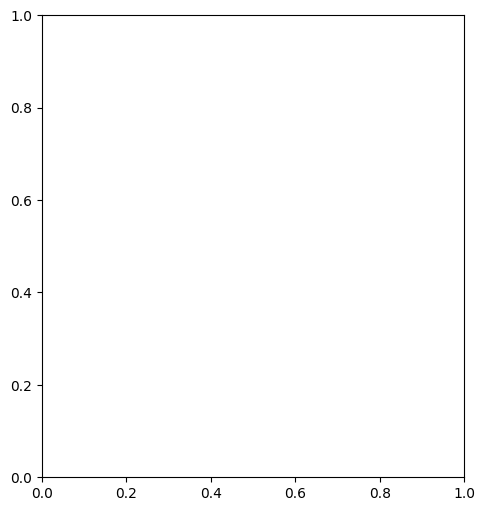

In [ ]:
plt.figure(figsize=(12, 6))

# Validation error subplot
plt.subplot(1, 2, 1)
plt.plot([i for i in range(num_epochs)], val_loss_values, label='Validation Error', marker='o')
plt.plot([i for i in range(num_epochs)], train_loss_values, label='Training Error', marker='x')
plt.title('Error vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

# Validation loss subplot
plt.subplot(1, 2, 2)
plt.plot([i for i in range(num_epochs)], train_acc, label='Validation Accuracy', marker='o')
plt.plot([i for i in range(num_epochs)], val_acc, label='Training Accuracy', marker='x')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Self-Attention

In [ ]:
# Get X, y and vocab size
seq_length = 128
step_size = 1
text = text[:100000]
X, y, vocab_size = char_to_index_one_hot(text, seq_length, step_size)

# Print the vocabulary size and the one-hot encoded sequence
print(f"Vocabulary Size: {vocab_size}")
print(f"X size: {X.shape}")
print(f"y size: {y.shape}")

In [ ]:
class TextGeneratorTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead, num_encoder_layers):
        super(TextGeneratorTransformer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # Transformer layers
        self.transformer = nn.Transformer(d_model=input_size, nhead=nhead, num_encoder_layers=num_encoder_layers)
        self.fc = nn.Linear(input_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.transformer(x)  # Transformer layer
        out_linear = self.fc(out[-1, :, :])  # Get the output from the last time step
        softmax_ = self.softmax(out_linear)

        return softmax_


In [ ]:
input_size = vocab_size  # The size of vocabulary (embedding size)
hidden_size = 128  # Number of hidden units in the RNN
num_layers = 1  # Number of RNN layers
output_size = vocab_size  # Output size should match the vocabulary size
nhead = 4
num_encoder_layers = 1

model = TextGeneratorTransformer(input_size, hidden_size, num_layers, output_size, nhead, num_encoder_layers)
#model.state_dict()
print(model)

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
learning_rate = 0.001
num_epochs = 10
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
batch_size = 100

# Create training data batches
num_batches = len(X_train) // batch_size
X_train_batches = []
y_train_batches = []

for i in range(num_batches):
    xbatch = X_train[i * batch_size: (i + 1) * batch_size]
    ybatch = y_train[i * batch_size: (i + 1) * batch_size]
    X_train_batches.append(xbatch)
    y_train_batches.append(ybatch)

# Create testing data batches
num_batches = len(X_test) // batch_size
X_test_batches = []
y_test_batches = []

for i in range(num_batches):
    xbatch = X_test[i * batch_size: (i + 1) * batch_size]
    ybatch = y_test[i * batch_size: (i + 1) * batch_size]
    X_test_batches.append(xbatch)
    y_test_batches.append(ybatch)


In [ ]:
X_train.shape, y_train.shape, X_train_batches[0].shape, y_train_batches[0].shape

In [ ]:
X_test.shape, y_test.shape, X_test_batches[0].shape, y_test_batches[0].shape

In [ ]:
  # Set the model to training mode
model = model.to(device)
for epoch in range(2):
    train_loss_values = []
    train_acc = []
    val_loss_values = []
    val_error = []
    val_acc = []
    i = 0
    total_step = X_train.shape[0]


    model.train()
    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
      X_batch = torch.Tensor(X_batch)
      y_batch = torch.Tensor(y_batch)
      pred = model(X_batch)
      pred_indices = torch.argmax(pred, dim=1)
      y_train_indices = torch.argmax(y_batch, dim=1)
      acc = (pred_indices == y_train_indices).sum().item()/y_train_indices.shape[0]
      loss_ = loss(pred, y_batch)
      i += 1
      optimizer.zero_grad()
      loss_.backward()
      optimizer.step()
      if i % 1000 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss_.item()))

      train_loss_values.append(loss_)
      train_acc.append(acc)


      model.eval()
      with torch.inference_mode():
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches):
          X_test_batch = torch.Tensor(X_test_batch)
          y_test_batch = torch.Tensor(y_test_batch)
          pred_test = model(X_test_batch)
          pred_test_indices = torch.argmax(pred_test, dim=1)
          y_test_indices = torch.argmax(y_test_batch, dim=1)
          acc_test = (pred_test_indices == y_test_indices).sum().item()/y_test_indices.shape[0]
          loss_test = loss(pred_test, y_test_batch)

      if i % 1000 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Test Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss_.item()))
      val_loss_values.append(loss_test)
      val_acc.append(acc_test)


In [ ]:
plt.figure(figsize=(12, 6))

# Validation error subplot
plt.subplot(1, 2, 1)
plt.plot([i for i in range(num_epochs)], val_loss_values, label='Validation Error', marker='o')
plt.plot([i for i in range(num_epochs)], train_loss_values, label='Training Error', marker='x')
plt.title('Error vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

# Validation loss subplot
plt.subplot(1, 2, 2)
plt.plot([i for i in range(num_epochs)], train_acc, label='Validation Accuracy', marker='o')
plt.plot([i for i in range(num_epochs)], val_acc, label='Training Accuracy', marker='x')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()